In [21]:
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
import networkx as nx
import osmnx as ox
import geopandas as gpd
import networkx as nx
from cartopy.geodesic import Geodesic
from shapely.geometry.polygon import Point, Polygon
from shapely.geometry import shape
from shapely.ops import unary_union
import nhstravel.loaders.lsoaloader as lsoaloader
import folium
import geopandas as gpd

In [22]:
#load in the post code to lsoa look up sheet
postcode_lookup = pd.read_csv('data/PCD_OA21_LSOA21_MSOA21_LAD_NOV22_UK_LU 3.csv', encoding = "ISO-8859-1")
postcode_lookup.head()

/var/folders/kt/92wnzvcj6qq_r6j3j19yp5lw0000gp/T/ipykernel_42936/1090205016.py:2: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  postcode_lookup = pd.read_csv('data/PCD_OA21_LSOA21_MSOA21_LAD_NOV22_UK_LU 3.csv', encoding = "ISO-8859-1")


,pcd7,pcd8,pcds,dointr,doterm,usertype,oa21cd,lsoa21cd,msoa21cd,ladcd,lsoa21nm,msoa21nm,ladnm,ladnmw
0,AB1 0AA,AB1 0AA,AB1 0AA,198001,199606.0,0,S00090303,S01006514,S02001237,S12000033,NaN,NaN,Aberdeen City,NaN
1,AB1 0AB,AB1 0AB,AB1 0AB,198001,199606.0,0,S00090303,S01006514,S02001237,S12000033,NaN,NaN,Aberdeen City,NaN
2,AB1 0AD,AB1 0AD,AB1 0AD,198001,199606.0,0,S00090399,S01006514,S02001237,S12000033,NaN,NaN,Aberdeen City,NaN
3,AB1 0AE,AB1 0AE,AB1 0AE,199402,199606.0,0,S00091322,S01006853,S02001296,S12000034,NaN,NaN,Aberdeenshire,NaN
4,AB1 0AF,AB1 0AF,AB1 0AF,199012,199207.0,1,S00090299,S01006511,S02001236,S12000033,NaN,NaN,Aberdeen City,NaN


In [45]:
#load in the hospital data set to get the postcodes for lookup
#load in the hospital sites data to be used to score potential viable locations and filter for Cambridge
hospitals = pd.read_csv('data/Hospital.csv')
gm_hospitals = hospitals.loc[hospitals['County'] == 'Greater Manchester']
#gm_hospitals

In [77]:
#define the target location post codes 
target_postcode1 = 'CB2 8AF'
target_postcode2 = 'CB2 0AY'
list_of_target_addresses = [target_postcode1, target_postcode2]
print(list_of_target_addresses)

['CB2 8AF', 'CB2 0AY']


In [78]:
target_coords = []
for loc in list_of_target_addresses:
    target_coords.append(ox.geocode(loc))


target_coords

[(52.19006495, 0.12399715), (52.1735278, 0.1358808)]

In [79]:
#get the lsoa 2021 code from the lookup file
lsoa_codes = []
lsoa_names = []
for postcode in list_of_target_addresses:
    lsoa_codes.append(postcode_lookup.loc[postcode_lookup['pcds'] == postcode]['lsoa21cd'].values[0])
    lsoa_names.append(postcode_lookup.loc[postcode_lookup['pcds'] == postcode]['ladnm'].values[0])

lsoa_names

['Cambridge', 'Cambridge']

In [80]:
#load in lsoa data using the loaders function in nhs travel
lsoa_with_population_pd1 = lsoaloader.build_lsoa_data_frame_for_area_england(lsoa_names[0])
remapped_lsoa1 = lsoaloader.load_geo_json_shapefiles_for_lsoas(lsoa_with_population_pd1, lsoa_names[0])

In [81]:
target_coords1 = target_coords[0]

gd = Geodesic()
bounding_poly1 = Polygon(gd.circle(lon=target_coords1[1], lat=target_coords1[0], radius=500))

target_point1 = Point(target_coords1[1], target_coords1[0])

neighboring_polys1 = {'lsoa_codes':[], 'population':[], 'polygons':[]}
for lsoa in remapped_lsoa1['features']:
    lsoa_polygon = shape(lsoa['geometry'])
    if lsoa_polygon.contains(target_point1) or bounding_poly1.intersects(lsoa_polygon):
        neighboring_polys1['lsoa_codes'].append(lsoa['properties']['LSOA21CD'])
        neighboring_polys1['population'].append(lsoa['properties']['all ages'])
        neighboring_polys1['polygons'].append(lsoa_polygon)

In [82]:
#load in lsoa data using the loaders function in nhs travel
lsoa_with_population_pd2 = lsoaloader.build_lsoa_data_frame_for_area_england(lsoa_names[0])
remapped_lsoa2 = lsoaloader.load_geo_json_shapefiles_for_lsoas(lsoa_with_population_pd1, lsoa_names[0])

In [83]:
target_coords2 = target_coords[1]

gd = Geodesic()
bounding_poly2 = Polygon(gd.circle(lon=target_coords2[1], lat=target_coords2[0], radius=500))

target_point2 = Point(target_coords2[1], target_coords2[0])

neighboring_polys2 = {'lsoa_codes':[], 'population':[], 'polygons':[]}
for lsoa in remapped_lsoa2['features']:
    lsoa_polygon = shape(lsoa['geometry'])
    if lsoa_polygon.contains(target_point2) or bounding_poly2.intersects(lsoa_polygon):
        neighboring_polys2['lsoa_codes'].append(lsoa['properties']['LSOA21CD'])
        neighboring_polys2['population'].append(lsoa['properties']['all ages'])
        neighboring_polys2['polygons'].append(lsoa_polygon)

In [84]:
neighboring_polys1_merged = unary_union(neighboring_polys1['polygons'])
neighboring_polys2_merged = unary_union(neighboring_polys2['polygons'])
bounding_poly_merged = unary_union([neighboring_polys1_merged, neighboring_polys2_merged])

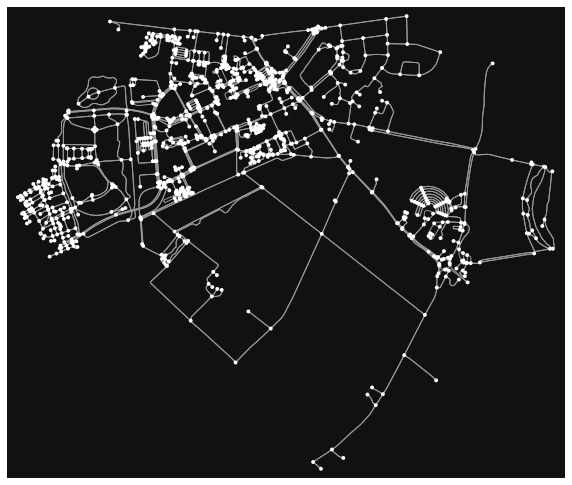

In [85]:
G = ox.graph_from_polygon(bounding_poly_merged)
#---------------------------------------------------------------------------------------
ox.plot_graph(G, figsize = (10,10));

In [95]:
nodes, edges = ox.graph_to_gdfs(G)
nodes

,y,x,street_count,highway,ref,geometry
osmid,,,,,,
554204,52.164666,0.162936,3,NaN,NaN,POINT (0.16294 52.16467)
554224,52.166433,0.159279,3,NaN,NaN,POINT (0.15928 52.16643)
554246,52.167209,0.157698,3,traffic_signals,NaN,POINT (0.15770 52.16721)
554253,52.169838,0.153947,3,NaN,NaN,POINT (0.15395 52.16984)
554257,52.171286,0.151719,3,NaN,NaN,POINT (0.15172 52.17129)
...,...,...,...,...,...,...
10700725505,52.176249,0.144609,3,crossing,NaN,POINT (0.14461 52.17625)
10700725510,52.176751,0.145584,3,crossing,NaN,POINT (0.14558 52.17675)
10700725512,52.176683,0.145695,3,crossing,NaN,POINT (0.14570 52.17668)


In [94]:
#convert the addresses to lat long coordinates and get the nearest node on the graph

target_node1 = ox.get_nearest_node(G, target_coords1)

target_node2 = ox.get_nearest_node(G, target_coords2)

list_of_target_nodes = [target_node1, target_node2]
list_of_target_coords = [target_coords1, target_coords2]

/usr/local/lib/python3.9/site-packages/osmnx/distance.py:356: UserWarning: The `get_nearest_node` function has been deprecated and will be removed in a future release. Use the more efficient `distance.nearest_nodes` instead.
  warnings.warn(msg)
/usr/local/lib/python3.9/site-packages/osmnx/distance.py:356: UserWarning: The `get_nearest_node` function has been deprecated and will be removed in a future release. Use the more efficient `distance.nearest_nodes` instead.
  warnings.warn(msg)


In [105]:
nodes_sample1

,y,x,street_count,highway,ref,geometry,lsoa_codes,lsoa_population


In [103]:
#get the dataframe of nodes that are in the neighboring polys and get the sample nodes with the corresponding population and lsoa codes
nodes_sample1 = pd.DataFrame(columns = nodes.columns)
list_of_lsoa_codes = []
list_of_pops = []


for i in range(len(neighboring_polys1['polygons'])):
    lsoa = neighboring_polys1['polygons'][i]
    for j in range(nodes.shape[0]):
        if lsoa.contains(nodes.iloc[j]['geometry']):
            nodes_sample1 = nodes_sample1.append(nodes.iloc[j])
            list_of_lsoa_codes.append(neighboring_polys1['lsoa_codes'][i])
            list_of_pops.append(neighboring_polys1['population'][i])

nodes_sample1['lsoa_codes'] = list_of_lsoa_codes
nodes_sample1['lsoa_population'] = list_of_pops

nodes_sample1 = nodes_sample1.drop(target_node1)

nodes_sample1

KeyError: '[9597215600] not found in axis'

In [72]:
nodes_sample2 = pd.DataFrame(columns = nodes.columns)
target_node2 = ox.get_nearest_node(G, target_coords2)

nodes

/usr/local/lib/python3.9/site-packages/osmnx/distance.py:356: UserWarning: The `get_nearest_node` function has been deprecated and will be removed in a future release. Use the more efficient `distance.nearest_nodes` instead.
  warnings.warn(msg)


,y,x,street_count,highway,geometry
osmid,,,,,
234977,53.456260,-2.245044,4,NaN,POINT (-2.24504 53.45626)
234978,53.457775,-2.245014,3,NaN,POINT (-2.24501 53.45778)
234981,53.464026,-2.245187,3,NaN,POINT (-2.24519 53.46403)
643145,53.467110,-2.229449,4,NaN,POINT (-2.22945 53.46711)
643147,53.462040,-2.223435,3,NaN,POINT (-2.22343 53.46204)
...,...,...,...,...,...
10741683676,53.457059,-2.225244,1,NaN,POINT (-2.22524 53.45706)
10741683678,53.457283,-2.224856,3,NaN,POINT (-2.22486 53.45728)
10741752574,53.456022,-2.225039,3,NaN,POINT (-2.22504 53.45602)


In [73]:
#get the dataframe of nodes that are in the neighboring polys and get the sample nodes with the corresponding population and lsoa codes
nodes_sample2 = pd.DataFrame(columns = nodes.columns)
list_of_lsoa_codes = []
list_of_pops = []


for i in range(len(neighboring_polys2['polygons'])):
    lsoa = neighboring_polys2['polygons'][i]
    for j in range(nodes.shape[0]):
        if lsoa.contains(nodes.iloc[j]['geometry']):
            nodes_sample2 = nodes_sample2.append(nodes.iloc[j])
            list_of_lsoa_codes.append(neighboring_polys2['lsoa_codes'][i])
            list_of_pops.append(neighboring_polys2['population'][i])

nodes_sample2['lsoa_codes'] = list_of_lsoa_codes
nodes_sample2['lsoa_population'] = list_of_pops

nodes_sample2 = nodes_sample2.drop(target_node2)

nodes_sample2

/var/folders/kt/92wnzvcj6qq_r6j3j19yp5lw0000gp/T/ipykernel_42936/195574021.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  nodes_sample2 = nodes_sample2.append(nodes.iloc[j])
/var/folders/kt/92wnzvcj6qq_r6j3j19yp5lw0000gp/T/ipykernel_42936/195574021.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  nodes_sample2 = nodes_sample2.append(nodes.iloc[j])
/var/folders/kt/92wnzvcj6qq_r6j3j19yp5lw0000gp/T/ipykernel_42936/195574021.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  nodes_sample2 = nodes_sample2.append(nodes.iloc[j])
/var/folders/kt/92wnzvcj6qq_r6j3j19yp5lw0000gp/T/ipykernel_42936/195574021.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use p

,y,x,street_count,highway,geometry,lsoa_codes,lsoa_population
3356855,53.464089,-2.23149,3,NaN,POINT (-2.2314901 53.4640888),E01034117,2202
3356856,53.462306,-2.229557,3,NaN,POINT (-2.2295567 53.462306),E01034117,2202
3356867,53.459216,-2.227673,3,NaN,POINT (-2.2276735 53.4592161),E01034117,2202
3356870,53.457735,-2.228518,3,NaN,POINT (-2.2285182 53.4577352),E01034117,2202
4618187,53.464435,-2.236179,3,NaN,POINT (-2.2361791 53.4644347),E01034117,2202
...,...,...,...,...,...,...,...
7542326833,53.455077,-2.245043,3,crossing,POINT (-2.2450434 53.4550774),E01005246,2541
8780919086,53.456255,-2.241908,3,NaN,POINT (-2.2419084 53.4562548),E01005246,2541
9034429699,53.45521,-2.237578,3,NaN,POINT (-2.2375782 53.4552104),E01005246,2541
9034456247,53.455475,-2.238086,3,NaN,POINT (-2.2380859 53.4554748),E01005246,2541


In [74]:
#creating a function to calculate a score from a list of lengths calculated from the target node to each of the 100 sample nodes
def create_score(list_of_lengths, list_of_multipliers):
    score = 1000
    for l, m in zip(list_of_lengths, list_of_multipliers):
        deduction = (((l/1000)/4.5)*60) * m * 5#get the length in km divide by speed 4.5 km/h then divide by 60 to get time in minutes
        score = score - deduction #decrement the score by the derivation of time taken to each of the 100 nodes
        return score

In [75]:
#define a function to calculate multiple shortest route lengths from the target node to each of the 100 sample nodes
def create_list_of_lengths(nodes_sample, target_node):
    list_of_lengths = []
    list_of_multipliers = []
    for node in nodes_sample.index:
        total_pop = nodes_sample['lsoa_population'].unique().sum()
        node_pop = nodes_sample['lsoa_population'][node]
        multiplier = 1 - (node_pop/total_pop)
        length = nx.shortest_path_length(G, source=node, target=target_node, weight='length') #calculate route from target node to sample node
        list_of_lengths.append(length) #append the length to the list
        list_of_multipliers.append(multiplier) #append the multipliers to the list for score creation
    
    return [list_of_lengths, list_of_multipliers]
    

In [76]:
#run the function defined above to generate a list of lengths between the target nodes and sample nodes
#then generate the score for each and store them in a dictionary
target_scores = {}
target1_lengths = create_list_of_lengths(nodes_sample1, list_of_target_nodes[0])
target2_lengths = create_list_of_lengths(nodes_sample2, list_of_target_nodes[1])
target_scores['Site 1'] = create_score(target1_lengths[0], target1_lengths[1])
target_scores['Site 2'] = create_score(target2_lengths[0], target2_lengths[1])
target_scores

NetworkXNoPath: Node 5401504032 not reachable from 3356308

In [ ]:
#print the scores for each proposed target site
print('The score for Site 1: {} is {}'.format(hospitals['Name'].iloc[target_index1], target_scores['Site 1']))
print('The score for Site 2: {} is {}'.format(hospitals['Name'].iloc[target_index2], target_scores['Site 2']))

The score for Site 1: CUH AT ROYAL PAPWORTH HOSPITAL is 958.8498947758429
The score for Site 2: NUFFIELD HEALTH CAMBRIDGE HOSPITAL is 967.9421196359928


In [68]:
#initiate dictionary to store routes for all 100 nodes for each proposed site
target_to_nodes_routes = {}
target_node_names = ['Site1', 'Site2']

In [69]:
list_of_samples = [nodes_sample1, nodes_sample2]

In [70]:
#generate multiple shortest routes for each site and store in dictionary for plotting
for site, target_node in zip(target_node_names, list_of_target_nodes):
    list_of_routes = []
    for node in nodes_sample1.index:
        route = nx.shortest_path(G, source=node, target=target_node, weight='length') #calculate route from target node to sample node
        list_of_routes.append(route) #append the length to the list
    target_to_nodes_routes[site] = list_of_routes
    


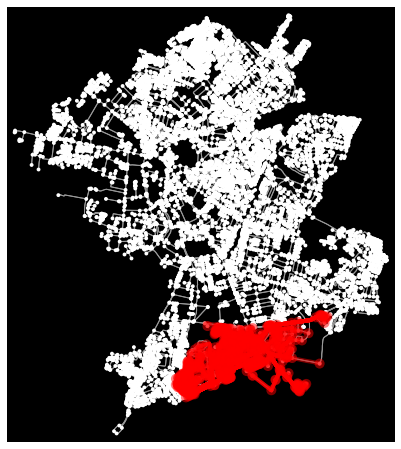

In [71]:
#plot the routes from Site 1 to all 100 sample nodes
fig, ax = ox.plot_graph_routes(G, target_to_nodes_routes['Site1'], route_linewidth=6, bgcolor='k')

KeyboardInterrupt: 

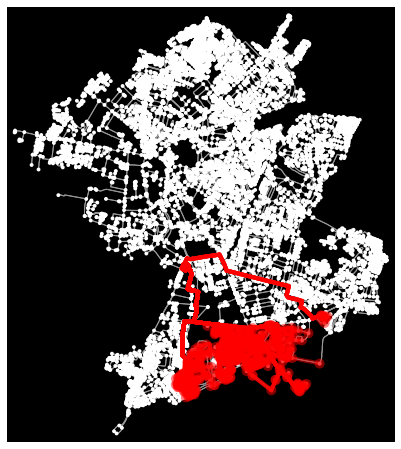

In [72]:
#plot the routes from Site 1 to all 100 sample nodes
fig, ax = ox.plot_graph_routes(G, target_to_nodes_routes['Site2'], route_linewidth=6, bgcolor='k')